## 机器学习纳米学位毕业项目

## 项目：猫狗大战


### 项目内容

猫狗大战项目是kaggle上的一个竞赛题目：[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)，目标是训练一个模型从给定的彩色图片中分辨出是猫还是狗，本质上是二分类问题（狗的类别是1，猫的类别是0）。本项目将利用keras提供的深度神经网络学习架构对训练数据集进行建模训练，然后对测试集的数据进行预测。  

模型评价的衡量指标要求采用二分类问题的对数损失，目标达到[kaggle Public Leaderboard](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/leaderboard)的前10%，即小于0.06127。  

要求可以复现，设置了随机种子2019。

我们将这个notebook分为不同的步骤，你可以使用下面的链接来浏览此notebook。

* [Step 0](#step0): 获取数据集
* [Step 1](#step1): 探索数据集
* [Step 2](#step2): 拆分训练集
* [Step 3](#step3): 异常值检测
* [Step 4](#step4): 数据集预处理
* [Step 5](#step5): 模型构建与训练
* [Step 6](#step6): 模型改进
* [Step 7](#step7): 模型预测与评估




---

<a id='step0'></a>
## 步骤 0: 获取数据集
数据集需要登录Kaggle网站才有权限，请自行访问[Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)下载，下载后得到一个zip压缩文件all.zip。

<a id='step1'></a>
## 步骤 1: 探索数据集

In [64]:
import zipfile
from tqdm import tqdm

def extract_zip_file(zip_file_name):
    '''
    # 解压一个zip文件，并实时显示进度
    '''
    with zipfile.ZipFile(zip_file_name, 'r') as zip_file:
        for file in tqdm(zip_file.namelist(), desc="Extract file " + zip_file_name):
            zip_file.extract(file, r"./")

In [65]:
import os
from pprint import pprint

In [66]:
working_path = os.getcwd()
pprint(os.listdir(working_path))

['.ipynb_checkpoints',
 'all.zip',
 'all_small.zip',
 'dogs_vs_cats.ipynb',
 'sample_submission.csv']


In [67]:
extract_zip_file("all.zip")

Extract file all.zip: 100%|██████████████████████| 3/3 [00:05<00:00,  2.83s/it]


In [68]:
pprint(os.listdir(working_path))

['.ipynb_checkpoints',
 'all.zip',
 'all_small.zip',
 'dogs_vs_cats.ipynb',
 'sample_submission.csv',
 'test.zip',
 'train.zip']


all.zip中包含测试集tain.zip、训练集test.zip和提交模板sample_submission.csv。

In [69]:
extract_zip_file("train.zip")

Extract file train.zip: 100%|███████████| 25001/25001 [00:28<00:00, 881.97it/s]


In [70]:
extract_zip_file("test.zip")

Extract file test.zip: 100%|████████████| 12501/12501 [00:14<00:00, 835.30it/s]


In [71]:
pprint(os.listdir(working_path))

['.ipynb_checkpoints',
 'all.zip',
 'all_small.zip',
 'dogs_vs_cats.ipynb',
 'sample_submission.csv',
 'test',
 'test.zip',
 'train',
 'train.zip']


In [72]:
import numpy as np
from glob import glob

org_train_path = os.path.join(working_path, "train" + os.sep)
org_test_path = os.path.join(working_path, "test" + os.sep)

org_train_files = np.array(glob(org_train_path + "*.jpg"))
org_test_files = np.array(glob(org_test_path + "*.jpg"))

n_org_train_files = org_train_files.size
n_org_test_files = org_test_files.size

# 打印数据集的数据量
print("There are total {} images in training set.".format(n_org_train_files))
print("There are total {} images in testing set.".format(n_org_test_files))

There are total 25000 images in training set.
There are total 12500 images in testing set.


In [73]:
import cv2  
from math import ceil
import matplotlib.pyplot as plt  
%matplotlib inline

def show_img(img_path, show_shape=False):
    '''
    # 显示一张RGB图片
    '''
    # 加载彩色（通道顺序为BGR）图像
    img = cv2.imread(img_path)
    # 将BGR图像转变为RGB图像以打印
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    # 设置图片标题
    if show_shape:
        plt.title(os.path.basename(img_path) + "\n " + str(img.shape))
    else:
        plt.title(os.path.basename(img_path))
    # 屏蔽坐标轴和刻度
    plt.axis("off")
    

def show_imgs(img_paths, idx_list, show_shape=False, figsize=(15.0, 6.0), n_cols=6):
    '''
    # 显示指定目录下索引序列分别对应的图像
    # img_paths: 图片文件名列表
    # idx_list: 指定索引列表
    # show_shape
    # figsize：画布大小
    # n_cols：每行显示的图片的张数和索引数的较小者
    # figsize和n_cols的存在主要是为了适应不同的显示设备，方便用户自己根据效果微调
    '''
    n_idx = len(idx_list)
    if n_idx < n_cols:
        n_cols = n_idx
    n_rows = int(ceil(n_idx / n_cols))
    plt.figure(figsize=figsize)
    for i,idx in enumerate(idx_list): 
        plt.subplot(n_rows, n_cols, i+1)
        show_img(img_paths[idx], show_shape)

In [77]:
figsize=(15.0, 6.0)
n_cols=5
n_show_imgs = 10
# 设置随机种子，以便结果可复现
np.random.seed(2019)

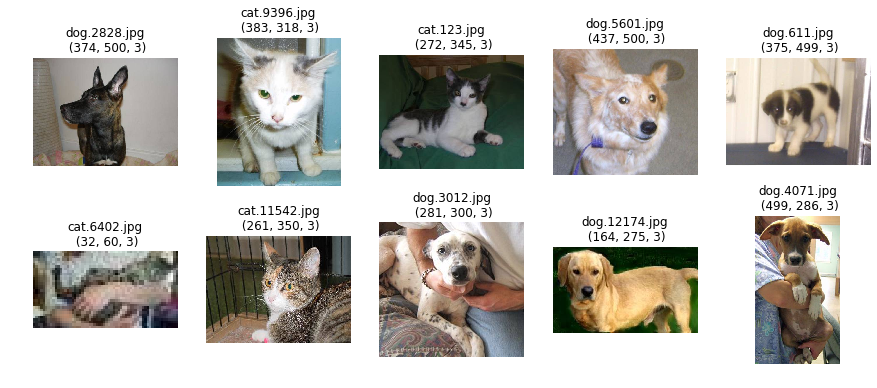

In [78]:
# 随机产生一组不重复索引列表,显示训练集中对应索引的图像
idx_list = np.random.choice(n_org_train_files, size=n_show_imgs, replace=False)
show_imgs(org_train_files, idx_list, True, figsize, n_cols)

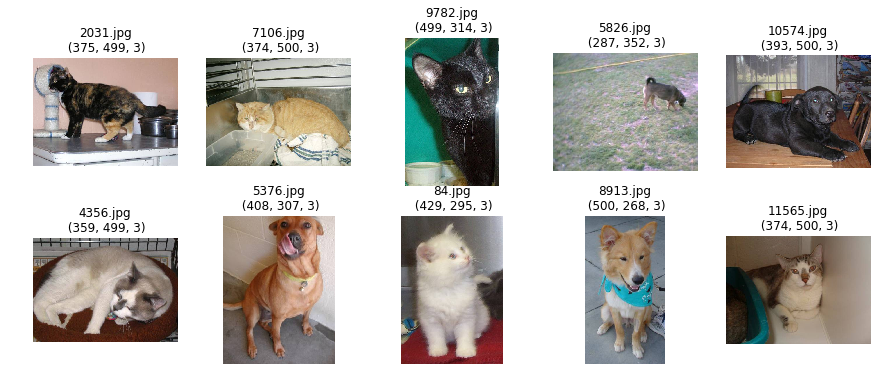

In [79]:
# 随机产生一组不重复索引列表,显示测试集中对应索引的图像
idx_list = np.random.choice(n_org_test_files, size=n_show_imgs, replace=False)
show_imgs(org_test_files, idx_list, True, figsize, n_cols)

In [80]:
import pandas as pd

csv_file = working_path + os.sep + "sample_submission.csv"
df = pd.read_csv(csv_file)
print(csv_file)
print(df.head())

E:\data\sample_submission.csv
   id  label
0   1    0.5
1   2    0.5
2   3    0.5
3   4    0.5
4   5    0.5


<a id='step2'></a>
## 步骤 2: 拆分训练集

后面使用Keras的ImageDataGenerator做预处理需要将不同种类的图片分在不同的文件夹中，这里新建train2和test2目录(避免出错后又要重新解压，所以拷贝一份出来操作），train2目录下包含cats和dogs子目录，分别存放训练集中猫的图片和狗的图片。test2目录下包含test子目录，存放测试集中的图片。

In [81]:
from shutil import rmtree

def create_folder(path):
    '''
    # 创建一个目录，如果目录已存在，则先删除再重新创建
    '''
    if os.path.exists(path):
        rmtree(path)
    os.mkdir(path)

In [137]:
train_path = os.path.join(working_path, "train2" + os.sep)
test_dir = os.path.join(working_path, "test2" + os.sep)

cats_train_path = os.path.join(train_path, "cats" + os.sep)
dogs_train_path = os.path.join(train_path, "dogs" + os.sep)
test_path = os.path.join(test_dir, "test" + os.sep)

# 新建train2目录，然后创建子目录cats和dogs
create_folder(train_path)
os.mkdir(cats_train_path)
os.mkdir(dogs_train_path)

# 新建test2目录，然后常见子目录test
create_folder(test_dir)
os.mkdir(test_path)

In [83]:
# 一次生成batch_size个文件列表
def get_batch_objs(objs_list, batch_size):
    n_objs = len(objs_list)
    for begin in range(0, n_objs, batch_size):
        end = min(begin + batch_size, n_objs)
        yield objs_list[begin:end]

In [182]:
# 批次拷贝文件
def copy_batch_files(org_path, dest_path, files_list, batch_size=100):
    n_batches = int(ceil(len(files_list) / batch_size))
    for i in tqdm(range(n_batches)):
        for file_name in next(get_batch_objs(files_list, batch_size)):
            copyfile(org_path + file_name, dest_path + file_name)

In [111]:
from shutil import copyfile

train_file_list = os.listdir(org_train_path)
test_file_list = os.listdir(org_test_path)

cats_file_list = [file_name for file_name in train_file_list if "cat" in file_name]
dogs_file_list = [file_name for file_name in train_file_list if "dog" in file_name]

In [138]:
# 批量拷贝图片
copy_batch_size = 12500

copy_batch_files(org_train_path, dogs_train_path, dogs_file_list, batch_size=copy_batch_size)
copy_batch_files(org_train_path, cats_train_path, cats_file_list, batch_size=copy_batch_size)
copy_batch_files(org_test_path, test_path, test_file_list, batch_size=copy_batch_size)


















  0%|                                                    | 0/1 [00:00<?, ?it/s]
















100%|████████████████████████████████████████████| 1/1 [00:12<00:00, 12.26s/it]

































  0%|                                                    | 0/1 [00:00<?, ?it/s]
















100%|████████████████████████████████████████████| 1/1 [00:10<00:00, 10.16s/it]

































  0%|                                                    | 0/1 [00:00<?, ?it/s]
















100%|████████████████████████████████████████████| 1/1 [00:12<00:00, 12.80s/it]


















In [163]:
# 加载数据集
dogs_train_files = np.array(glob(dogs_train_path + "*.jpg"))
cats_train_files = np.array(glob(cats_train_path + "*.jpg"))
test_files = np.array(glob(test_path + "*.jpg"))

n_dogs_train_files = dogs_train_files.size
n_cats_train_files = cats_train_files.size
n_test_files = test_files.size

# 打印数据集的数据量
print("There are total {} dog images in training set.".format(n_dogs_train_files))
print("There are total {} cat images in training set.".format(n_cats_train_files))
print("There are total {} images in testing set.".format(n_test_files))

There are total 12500 dog images in training set.
There are total 12500 cat images in training set.
There are total 12500 images in testing set.


In [164]:
# 显示前n张图像
n_heads = 5
head_idx_list = range(n_heads)

The first 5 images of dogs and cats respectively in training set before being shuffled：


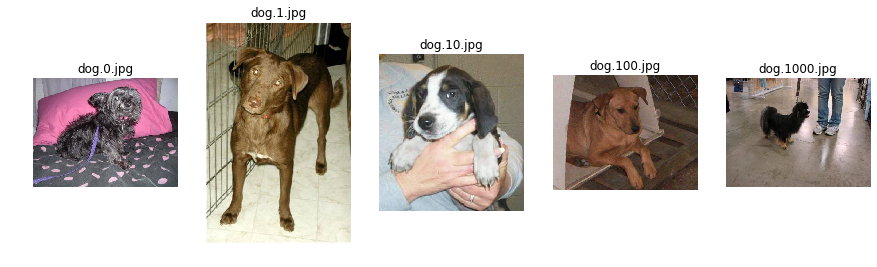

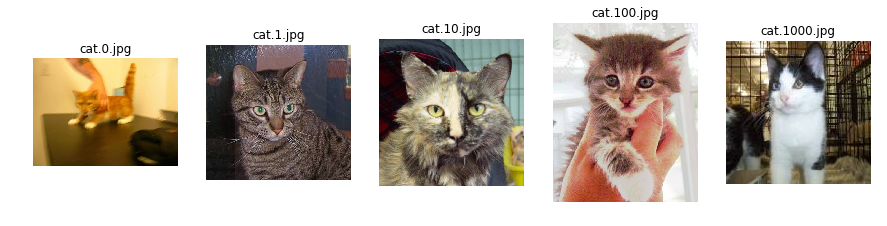

In [165]:
print("The first {} images of dogs and cats respectively in training set before being shuffled：".format(n_heads))
show_imgs(dogs_train_files, head_idx_list, False, figsize, n_cols)
show_imgs(cats_train_files, head_idx_list, False, figsize, n_cols)

In [166]:
# 随机打乱训练集
np.random.shuffle(dogs_train_files)
np.random.shuffle(cats_train_files)

The first 5 images of dogs and cats respectively in training set after being shuffled：


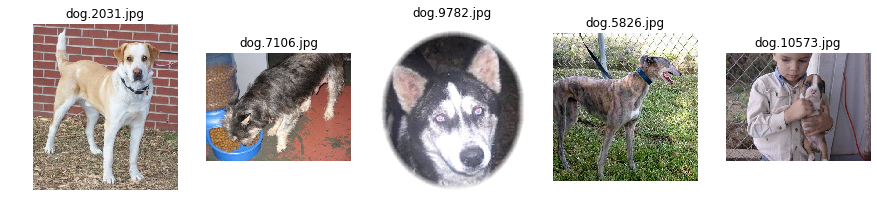

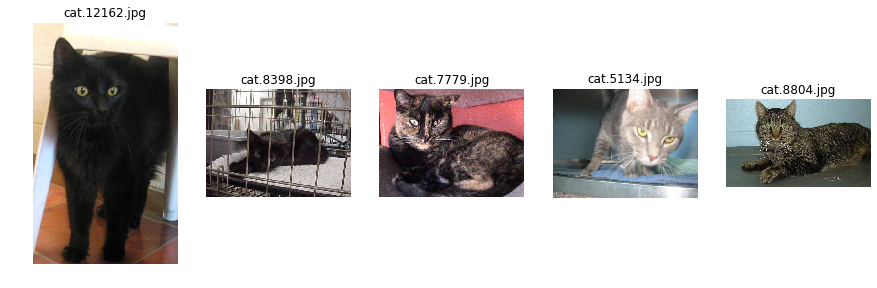

In [167]:
print("The first {} images of dogs and cats respectively in training set after being shuffled：".format(n_heads))
show_imgs(dogs_train_files, head_idx_list, False, figsize, n_cols)
show_imgs(cats_train_files, head_idx_list, False, figsize, n_cols)

<a id='step3'></a>
## 步骤 3: 异常值检测
在这个部分中，我们使用带基于 [ImageNet](http://www.image-net.org/) 数据集的预训练权重的[Xception](https://arxiv.org/abs/1610.02357)模型分别去预测图像中的狗和猫（使用基于ImageNet预训练模型训练前需要做一些预处理(图片转成四维张量，张量归一化等，其中Xception的尺寸要求是299 x 299。参考来源：[keras之预训练模型Application](https://blog.csdn.net/u010159842/article/details/79168615)），然后对照[ImageNet的1000个种类清单](https://blog.csdn.net/zhangjunbob/article/details/53258524)检查Top-5的预测结果。  

下面是ImageNet数据集的1000个分类中对应为狗和猫的列表，其中狗包含118种，猫包含7种，数据来源：https://zhuanlan.zhihu.com/p/34068451?edition=yidianzixun&utm_source=yidianzixun&yidian_docid=0IQskNR8

In [168]:
dogs = [
    'n02085620','n02085782','n02085936','n02086079','n02086240','n02086646','n02086910','n02087046' 
    ,'n02087394','n02088094','n02088238','n02088364','n02088466','n02088632','n02089078','n02089867'
    ,'n02089973','n02090379','n02090622','n02090721','n02091032','n02091134','n02091244','n02091467'
    ,'n02091635','n02091831','n02092002','n02092339','n02093256','n02093428','n02093647','n02093754'
    ,'n02093859','n02093991','n02094114','n02094258','n02094433','n02095314','n02095570','n02095889'
    ,'n02096051','n02096177','n02096294','n02096437','n02096585','n02097047','n02097130','n02097209'
    ,'n02097298','n02097474','n02097658','n02098105','n02098286','n02098413','n02099267','n02099429'
    ,'n02099601','n02099712','n02099849','n02100236','n02100583','n02100735','n02100877','n02101006'
    ,'n02101388','n02101556','n02102040','n02102177','n02102318','n02102480','n02102973','n02104029'
    ,'n02104365','n02105056','n02105162','n02105251','n02105412','n02105505','n02105641','n02105855'
    ,'n02106030','n02106166','n02106382','n02106550','n02106662','n02107142','n02107312','n02107574'
    ,'n02107683','n02107908','n02108000','n02108089','n02108422','n02108551','n02108915','n02109047'
    ,'n02109525','n02109961','n02110063','n02110185','n02110341','n02110627','n02110806','n02110958'
    ,'n02111129','n02111277','n02111500','n02111889','n02112018','n02112137','n02112350','n02112706'
    ,'n02113023','n02113186','n02113624','n02113712','n02113799','n02113978']

cats=[
    'n02123045','n02123159','n02123394','n02123597','n02124075','n02125311','n02127052']

In [169]:
from keras.preprocessing import image

def path_to_tensor(img_path, target_size=(299, 299)):
    '''
    # 将一张图像转为(1, target_width, target_height,target_depth)的4维张量并返回
    # 彩色图片有RGB三个通道，所以深度为3
    '''
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=target_size)
    # 默认将PIL.Image.Image类型转化为格式为((299, 299, 3)的3维张量
    x = image.img_to_array(img)
    # 默认将3维张量转化为格式为(1, 299, 299 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, target_size=(299, 299)):
    '''
    # 将图片列表中的图片都转为指定shape的4维张量然后合并为一个数组返回
    '''
    list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [170]:
# 对照列表检查预测结果
def dogs_and_cats_detector(y_preds, check_list):
    n_preds = len(y_preds)
    results = np.full(n_preds, True, dtype=bool) 
    for i in range(n_preds):
        for y_pred in y_preds[i]:
            result = True
            if y_pred[0] in check_list:
                break
        else:
            results[i] = False
    return list(results)

In [171]:
# 分批预测，并对照ImageNet数据集的列表检查是否预测准确
def model_predict_and_check(dogs, cats, model, preprocess_input, decode_predictions, target_size=(299, 299), batch_size=64, topN=5):
    # 这里猫狗的图片数量相等，所以随意取了狗的数量
    n_batches = int(ceil(n_dogs_train_files / batch_size))
    
    y_preds_dogs = []
    y_preds_cats = []
    results_dogs = []
    results_cats = []
    
    for i in tqdm(range(n_batches), "batch predict and check with batch_size=" + str(batch_size)):
        batch_preds_dogs = decode_predictions(model.predict(
                                preprocess_input(paths_to_tensor(next(get_batch_objs(dogs_train_files, batch_size)), target_size))),
                                top=topN)
        batch_preds_cats = decode_predictions(model.predict(
                                preprocess_input(paths_to_tensor(next(get_batch_objs(cats_train_files, batch_size)), target_size))),
                                top=topN)   
        batch_results_dogs = dogs_and_cats_detector(batch_preds_dogs, dogs)
        batch_results_cats = dogs_and_cats_detector(batch_preds_cats, cats)
        
        y_preds_dogs.extend(batch_preds_dogs)
        y_preds_cats.extend(batch_preds_cats)
        results_dogs.extend(batch_results_dogs)
        results_cats.extend(batch_results_cats)
        
    return y_preds_dogs, y_preds_cats, results_dogs, results_cats

In [180]:
check_batch_size = 128

In [174]:
from keras.applications.xception import Xception, preprocess_input, decode_predictions

model = Xception(weights="imagenet")
model_name = "Xception"
target_size = (299, 299)

In [ ]:
topN = 1
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

In [32]:
error_idx_dogs_Xception = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_Xception = [idx for idx,value in enumerate(results_cats) if not value]

Xception Top-1 predicts: There are 2 false dogs.


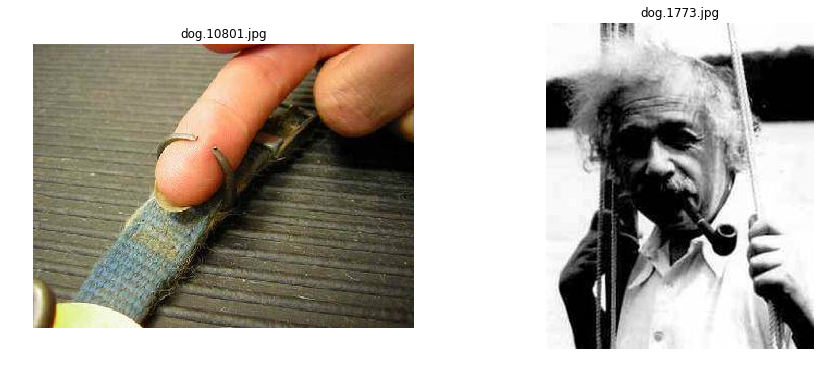

In [33]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_Xception)))
show_imgs(dogs_train_files, error_idx_dogs_Xception)

Xception Top-1 predicts: There are 1 false cats.


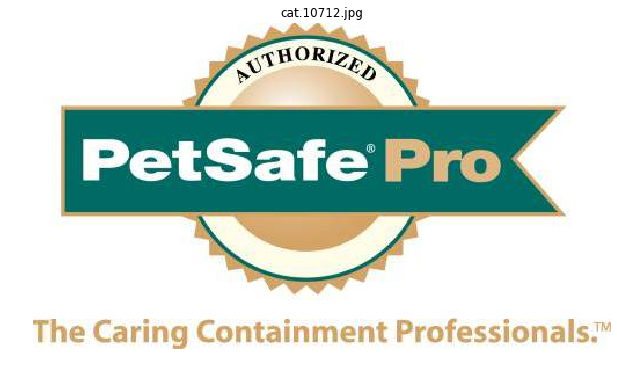

In [34]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_Xception)))
show_imgs(cats_train_files, error_idx_cats_Xception)

In [35]:
topN = 5
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

batch predict and check with batch_size=4: 100%|█| 1/1 [00:06<00:00,  6.37s/it]


In [36]:
error_idx_dogs_Xception = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_Xception = [idx for idx,value in enumerate(results_cats) if not value]

Xception Top-5 predicts: There are 2 false dogs.


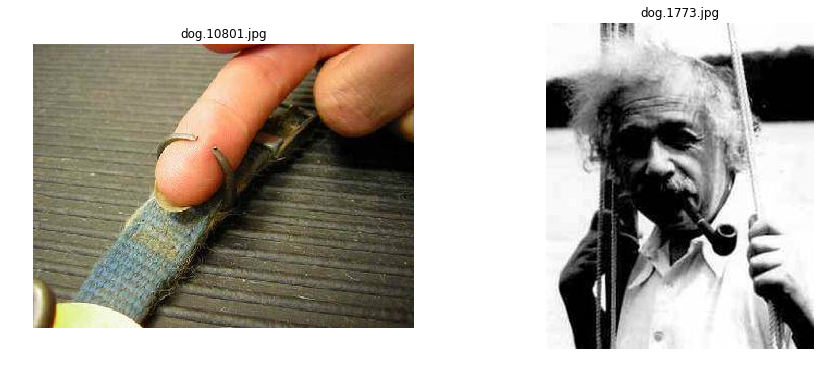

In [37]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_Xception)))
show_imgs(dogs_train_files, error_idx_dogs_Xception)

Xception Top-5 predicts: There are 1 false cats.


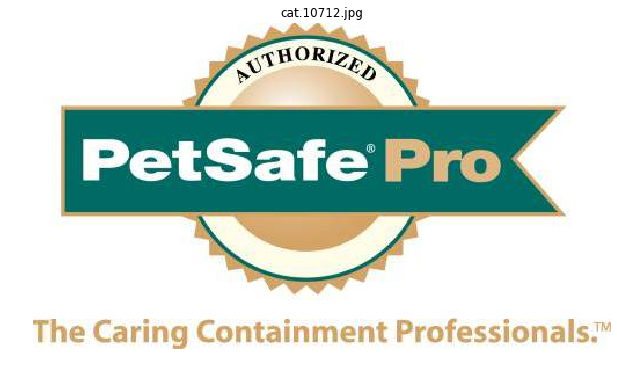

In [38]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_Xception)))
show_imgs(cats_train_files, error_idx_cats_Xception)

In [39]:
topN = 5

In [40]:
from keras.applications.xception import Xception, preprocess_input, decode_predictions

model = Xception(weights="imagenet")
model_name = "Xception"
target_size = (299, 299)

In [41]:
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

batch predict and check with batch_size=4: 100%|█| 1/1 [00:06<00:00,  6.68s/it]


In [42]:
error_idx_dogs_Xception = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_Xception = [idx for idx,value in enumerate(results_cats) if not value]

Xception Top-5 predicts: There are 2 false dogs.


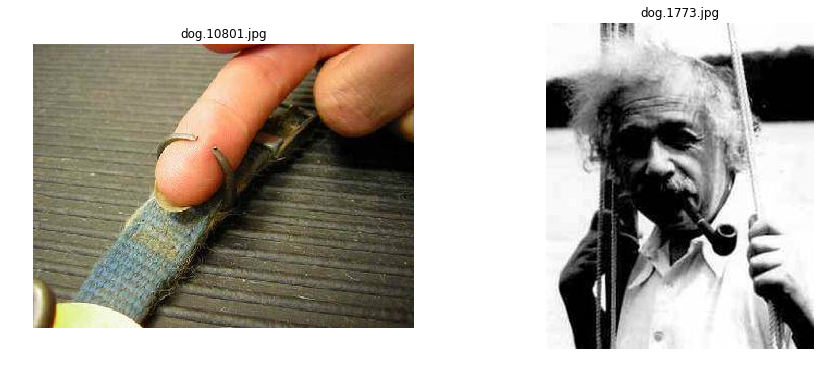

In [43]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_Xception)))
show_imgs(dogs_train_files, error_idx_dogs_Xception)

Xception Top-5 predicts: There are 1 false cats.


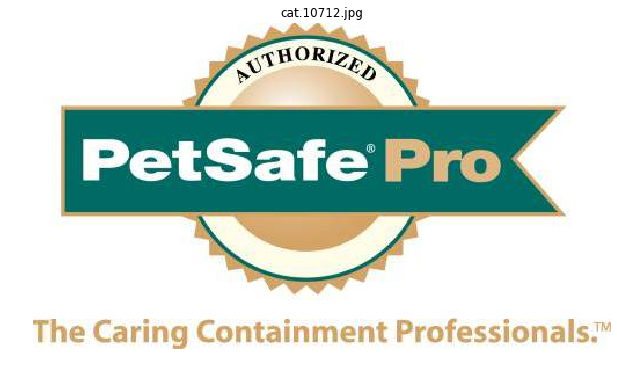

In [44]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_Xception)))
show_imgs(cats_train_files, error_idx_cats_Xception)

In [48]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

model = InceptionV3(weights="imagenet")
model_name = "InceptionV3"
target_size = (299, 299)

In [49]:
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

batch predict and check with batch_size=4: 100%|█| 1/1 [00:05<00:00,  5.19s/it]


In [50]:
error_idx_dogs_InceptionV3 = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_InceptionV3 = [idx for idx,value in enumerate(results_cats) if not value]

InceptionV3 Top-5 predicts: There are 2 false dogs.


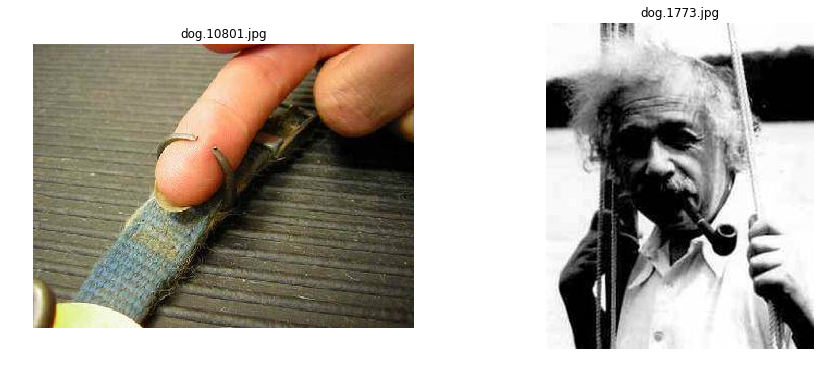

In [51]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_InceptionV3)))
show_imgs(dogs_train_files, error_idx_dogs_InceptionV3)

InceptionV3 Top-5 predicts: There are 1 false cats.


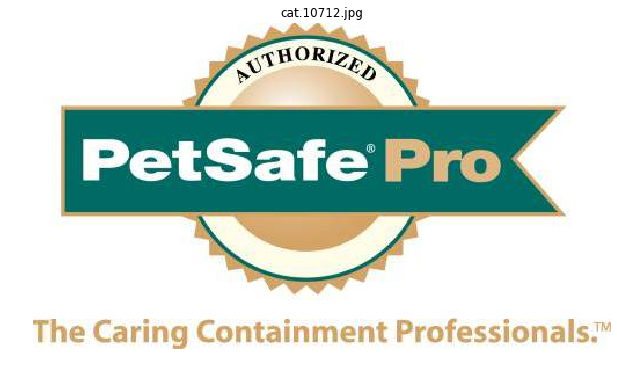

In [52]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_InceptionV3)))
show_imgs(cats_train_files, error_idx_cats_InceptionV3)

In [54]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

model = ResNet50(weights="imagenet")
model_name = "ResNet50"
target_size = (224, 224)

In [55]:
y_preds_dogs, y_preds_cats, results_dogs, results_cats = model_predict_and_check(dogs, cats,
                                                                                 model, preprocess_input, decode_predictions, 
                                                                                 target_size=target_size, 
                                                                                 batch_size=check_batch_size, 
                                                                                 topN=topN)

batch predict and check with batch_size=4: 100%|█| 1/1 [00:05<00:00,  5.46s/it]


In [56]:
error_idx_dogs_ResNet50 = [idx for idx,value in enumerate(results_dogs) if not value]
error_idx_cats_ResNet50 = [idx for idx,value in enumerate(results_cats) if not value]

ResNet50 Top-5 predicts: There are 2 false dogs.


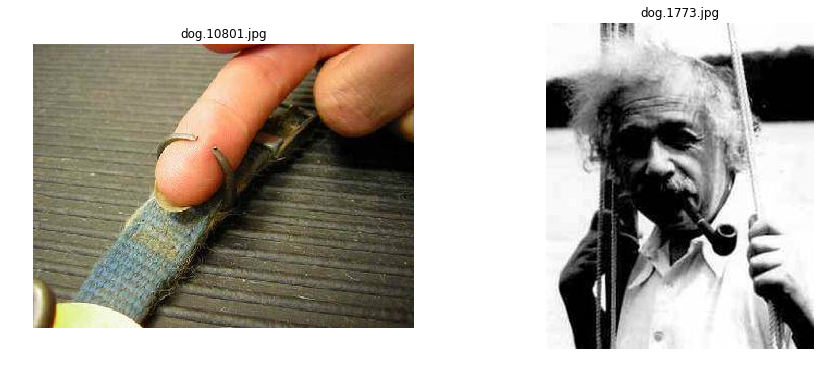

In [57]:
print("{} Top-{} predicts: There are {} false dogs.".format(model_name, topN, len(error_idx_dogs_ResNet50)))
show_imgs(dogs_train_files, error_idx_dogs_ResNet50)

ResNet50 Top-5 predicts: There are 1 false cats.


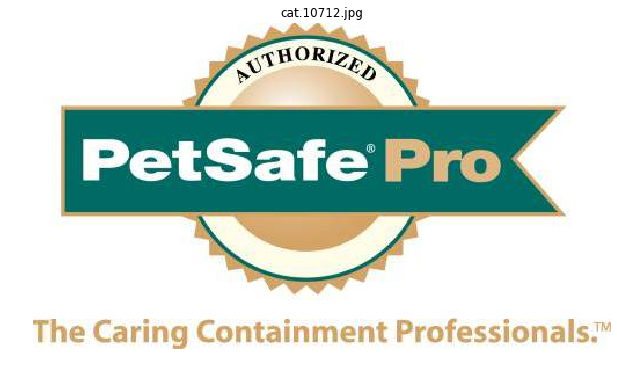

In [58]:
print("{} Top-{} predicts: There are {} false cats.".format(model_name, topN, len(error_idx_cats_ResNet50)))
show_imgs(cats_train_files, error_idx_cats_ResNet50)

In [59]:
# 求交集
error_idx_dogs = list(set(error_idx_dogs_Xception) & set(error_idx_dogs_InceptionV3) & set(error_idx_dogs_ResNet50))
error_idx_cats = list(set(error_idx_cats_Xception) & set(error_idx_cats_InceptionV3) & set(error_idx_cats_ResNet50))

Esembel(Xception/InceptionV3/ResNet50) Top-5 predicts: There are 2 false dogs.


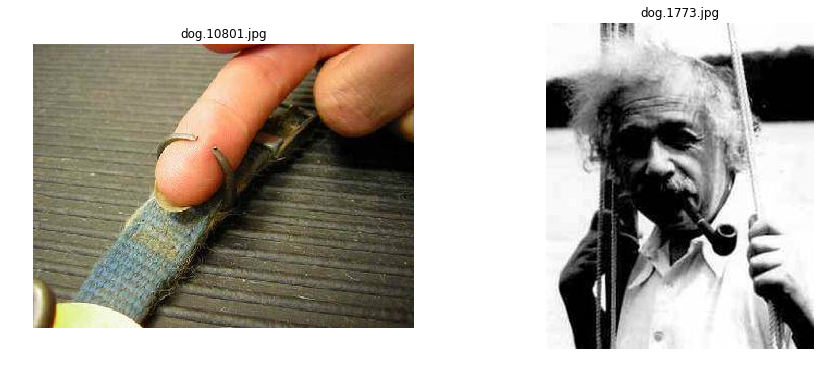

In [60]:
print("Esembel(Xception/InceptionV3/ResNet50) Top-{} predicts: There are {} false dogs.".format(topN, len(error_idx_dogs)))
show_imgs(dogs_train_files, error_idx_dogs)

Esembel(Xception/InceptionV3/ResNet50) Top-5 predicts: There are 1 false cats.


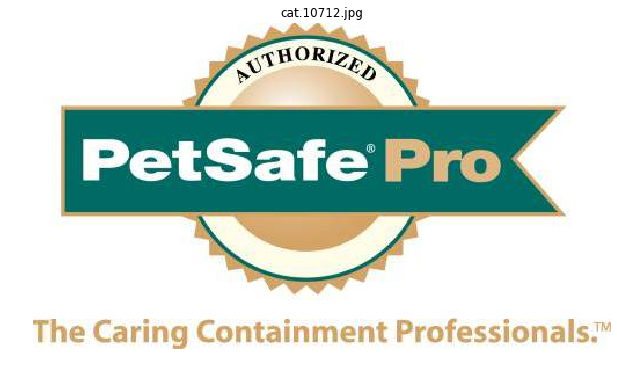

In [61]:
print("Esembel(Xception/InceptionV3/ResNet50) Top-{} predicts: There are {} false cats.".format(topN, len(error_idx_cats)))
show_imgs(cats_train_files, error_idx_cats)

<a id='step4'></a>
## 步骤 4: 数据集预处理

### 数据集预处理

In [62]:
# 剔除异常值
from shutil import move

# 在train2下面新建一个error_files用来保存错误的图片（不区分猫狗）
error_files_path = os.path.join(train_path, "error_files" + os.sep)
create_folder(error_files_path)

# 分批移动错误图片
def move_error_files(error_idx_list, files_list, batch_size=64):
    # 用另外的变量保存，因为索引跟图片没有强相关，多次执行会不断迭代
    update_files_list = [item for idx, item in enumerate(files_list) if idx not in error_idx_list]
    n_batches = int(ceil(len(error_idx_list) / batch_size))
    for _ in tqdm(range(n_list)):
        for idx in next(get_batch_objs(error_idx_list, batch_size)):
            if (os.path.isfile(files_list[idx])):
                move(files_list[idx], error_files_path)
    return update_files_list

move_batch_size = 2
dogs_train = move_error_files(error_idx_dogs, dogs_train_files, move_batch_size)
cats_train = move_error_files(error_idx_cats, cats_train_files, move_batch_size)

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


In [63]:
print(os.listdir(error_files_path))

['cat.10712.jpg', 'dog.10801.jpg', 'dog.1773.jpg']


使用[keras.ImageDataGenerator](https://blog.csdn.net/jacke121/article/details/79245732)对数据集进行预处理，比如图像像素缩放、[数据增强](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)（可选）等。

In [ ]:
from keras.layers import Input
from keras.model import Model
from keras.preprocessing.image import ImageDataGenerator

def write_gap(model_name, target_size=（299, 299）, lambda_func=None):
    # 实例化一个keras张量
    input_tensor = Input(*target_size, 3)
    x = input_tensor
    # ResNet50还需要去中心化
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    # 提取基于ImageNet数据集预训练的bottleneck向量，并加全局平均池化层以减少训练参数和降低过拟合
    base_model = eval(model_name)(input_tensor=x, weights="imagenet", include_top=False, pooling="avg")
    base_model = eval(model_name)(base_model.input, GlobalAveragePooling2D)()(base_model.output)
    
    preprocess_batch_size = 
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(shuffle=False, batch_size=batch_size)
    
    

<a id='step5'></a>
## 步骤 5: 模型构建与训练
使用[迁移学习](http://arxiv.org/abs/1411.1792)，下面的部分集成了3个预训练的模型[Xception](https://arxiv.org/abs/1610.02357)、[InceptionV3](https://arxiv.org/abs/1512.00567)、[ResNet50](https://arxiv.org/abs/1512.03385)来搭建CNN，引用前辈预训练过的[Xception的特征向量](https://github.com/ypwhs/dogs_vs_cats/releases/download/gap/gap_Xception.h5)、[InceptionV3的特征向量](https://github.com/ypwhs/dogs_vs_cats/releases/download/gap/gap_InceptionV3.h5)、[ResNet50的特征向量](https://github.com/ypwhs/dogs_vs_cats/releases/download/gap/gap_ResNet50.h5)。使用[集成方法](https://cseweb.ucsd.edu/~yfreund/papers/IntroToBoosting.pdf)把多个弱学习器模型变成一个强学习器模型，可以显著提高模型的准确率与鲁棒性。

### 提取特征向量

In [ ]:
import h5py
from sklearn.utils import shuffle

X_train_Esembel = []
X_test_Esembel = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as f:
        X_train_Esembel.append(np.array(f['train']))
        X_test_Esembel.append(np.array(f['test']))
        y_train_Esembel = np.array(f['label'])

X_train_Esembel = np.concatenate(X_train_Esembel, axis=1)
X_test_Esembel = np.concatenate(X_test_Esembel, axis=1)

X_train_Esembel, y_train_Esembel = shuffle(X_train_Esembel, y_train_Esembel)

### 模型架构

In [151]:
from keras.models import Sequential, Model
from keras.layers import Input, GlobalAveragePooling2D，Dropout, Dense

# 定义网络框架
input_tensor = Input(X_train_Esembel.shape[1:])
X = Dropout(0.5)(input_tensor)
X = Dense(2, activation='softmax')(X)
Ensembel_model = Model(input_tensor, X)
           
# 输出网络框架     
Ensembel_model.summary()

SyntaxError: invalid character in identifier (<ipython-input-151-e96e8adc63f8>, line 2)

In [ ]:
# 可视化模型
from  keras.utilskeras.ut  import plot_model
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

plot_model(Ensembel_model, to_file='Ensembel_model.png')
SVG(model_to_dot(Ensembel_model).create(prog='dot', format='svg'))

In [ ]:
# 超参
optimizer="adadelta"

# 编译模型 
Esembel_model.compile(loss="binary__crossentropy", optimizer=optimizer, metrics=["accuracy"])

优化器还可以选择[Adagrad](https://keras.io/optimizers/#adagrad)和[Adam](https://keras.io/optimizers/#adam)等，这里先用[adadelta](https://keras.io/optimizers/#adadelta)尝试来自同学们的经验之谈，更多优化器的对比可以参考[An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)。

### 训练模型

In [ ]:
from keras.callbacks import ModelCheckpoint

# 使用模型检查点（model checkpointing）来储存具有最低验证集 loss 的模型。
saved_models_path = os.path.join(working_path, "saved_models" + os.sep)
create_folder(saved_models_path)

Esembel_h5_file = saved_models_path + "weights.best.Esembel.hdf5'
Esembel_checkpointer = ModelCheckpoint(Esembel_h5_file, verbose=1, save_best_only=True)

In [ ]:
# 超参
epochs = 8
batch_size = 128

# 训练集的20%用做交叉验证
start_time = time()
Esembel_history = Esembel_model.fit(X_train_Esembel, y_train_Esembel, 
                                    validation_split=0.2
                                    epochs=epocsh, batch_size=batch_size, callbacks=[Esembel_checkpointer], verbose=1)
end_time = time()
eclapse = end_time - start_time

下面的函数实现loss和accuracy的可视化，参考：[可视化keras模型训练历史](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)

In [ ]:
# 绘制准确率和loss曲线图
def show_loss_and_acc(model_name):
    history = eval(model_name + "_history")
    
    plt.subplot(121)
    plt.plot(history.history['loss'], 'blue', label='Training Loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation Loss')
    plt.title(model_name + 'model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    
    plt.subplot(122)
    plt.plot(history.history['acc'], 'blue', label='Training Accuracy')
    plt.plot(history.history['val_acc'], 'green', label='Validation Accuracy')
    plt.title(model_name + 'model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
 
    plt.show()

In [ ]:
print("current hyperparameters of Esembel model: epoch={}, batch_size={}, optimizer={} \n eclapse time: {} seconds".format(epochs, batch_size, optimizer, eclapse))
# 可视化loss和accuracy曲线
show_loss_and_acc("Esembel")

<a id='step6'></a>
## 步骤 6: 模型改进

<a id='step7'></a>
## 步骤 7: 模型预测与评估

In [ ]:
# 加载具有最好验证loss的模型
Esembel_model.load_weights(Esembel_h5_file)

In [ ]:
# 预测测试集的分类（狗的类别是1，猫的类别是0）
# y_preds_Esembel = Esembel_model.predict(X_test_Esembel, verbose=1)
y_preds_Esembel = [np.argmax(Esembel_model.predict(np.expand_dims(feature, axis=0))) for feature in X_test_Esembel]

In [ ]:
# 将预测值限制到了[0.005, 0.995]区间
# y_pred = y_pred.clip(min=0.005, max=0.995)

In [ ]:
# 按格式输出预测结果到sample_submission.csv
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('preds.csv', index=None)

In [ ]:
print(df.head())